In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
import smashpy
sf = smashpy.smashpy()

 * Initialising ...



# Loading annData object

In [7]:
obj = sc.read_h5ad('../../../../External_datasets/Healthy_foetal_organ_20pct.h5ad')

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [8]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

23054 genes across 42351 cells


#### Removing general genes

In [9]:
s1 = time.time()

In [10]:
obj = sf.remove_general_genes(obj)

#### Removing house-keeping genes

http://www.housekeeping.unicamp.br/?homePageGlobal

In [11]:
obj = sf.remove_housekeepingenes(obj, path="../../data/house_keeping_genes_human_foetal_HSC.txt")
obj = sf.remove_housekeepingenes(obj, path="../../data/house_keeping_genes_human_foetal_liver.txt")

#### Removing genes expressed in less than 30% within groups

In [12]:
obj = sf.remove_features_pct(obj, group_by="organ", pct=0.3)

#### Removing genes expressed in more than 50% in a given group where genes are expressed for more 75% within a given group

In [13]:
obj = sf.remove_features_pct_2groups(obj, group_by="organ", pct1=0.75, pct2=0.5)

#### Revert PCA

In [14]:
obj = sf.scale_filter_features(obj, n_components=None, filter_expression=True)

Fraction passing PCA: 0.868165417707466


#### ensemble_learning

In [15]:
s2 = time.time()

Running with Balanced Random Forest


<Figure size 432x288 with 0 Axes>

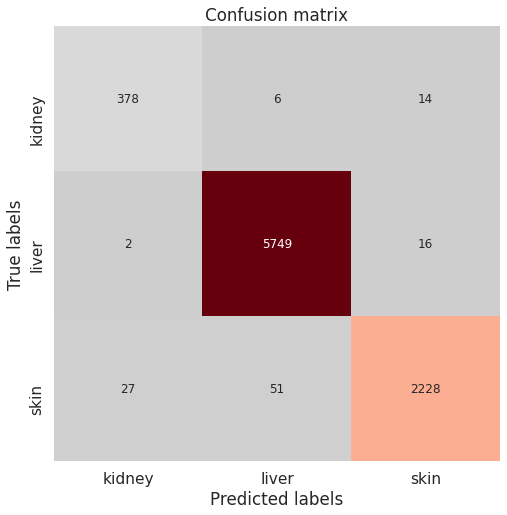

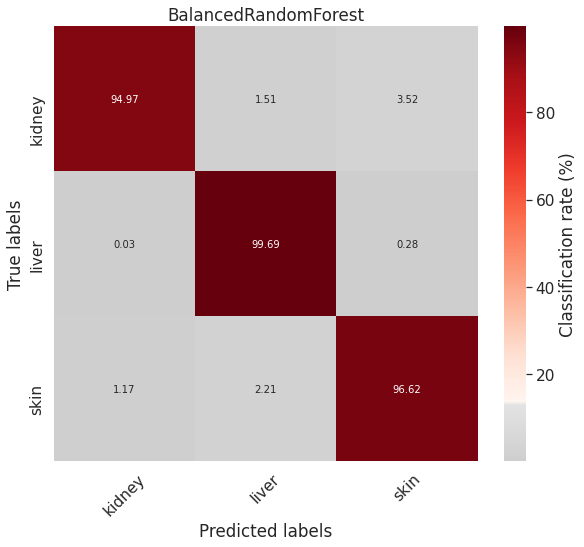

Accuracy: 0.986306221225357: Misclassification: 0.01369377877464295
              precision    recall  f1-score   support

      kidney       0.93      0.95      0.94       398
       liver       0.99      1.00      0.99      5767
        skin       0.99      0.97      0.98      2306

    accuracy                           0.99      8471
   macro avg       0.97      0.97      0.97      8471
weighted avg       0.99      0.99      0.99      8471



In [16]:
clf = sf.ensemble_learning(obj, group_by="organ", classifier="BalancedRandomForest", balance=True, verbose=True)

#### gini_importance

In [17]:
selectedGenes, selectedGenes_dict = sf.gini_importance(obj, clf, group_by="organ", verbose=True, restrict_top=("local", 20))

In [18]:
e2 = time.time()

#### Classifiers

<Figure size 432x288 with 0 Axes>

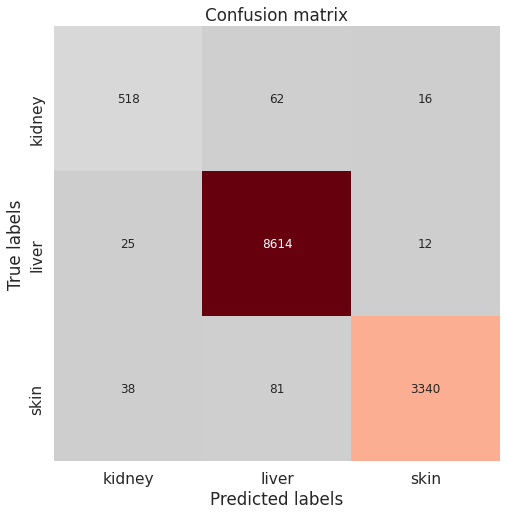

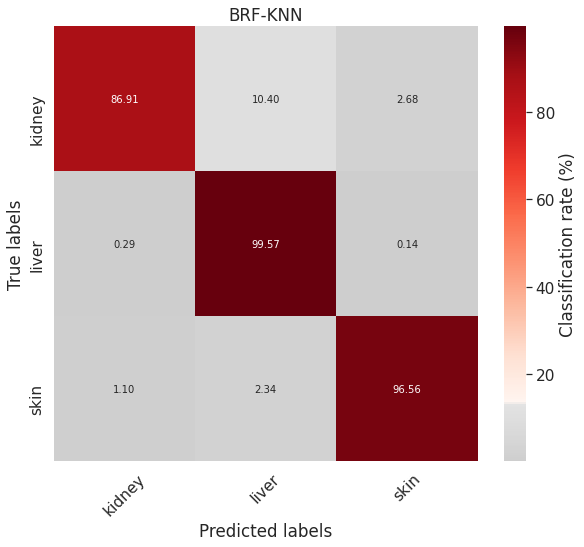

Accuracy: 0.9815835038564458: Misclassification: 0.01841649614355423
              precision    recall  f1-score   support

      kidney       0.89      0.87      0.88       596
       liver       0.98      1.00      0.99      8651
        skin       0.99      0.97      0.98      3459

    accuracy                           0.98     12706
   macro avg       0.96      0.94      0.95     12706
weighted avg       0.98      0.98      0.98     12706



In [19]:
sf.run_classifiers(obj, group_by="organ", genes=selectedGenes, classifier="KNN", balance=True, title="BRF-KNN")

#### Sorting genes per cluster

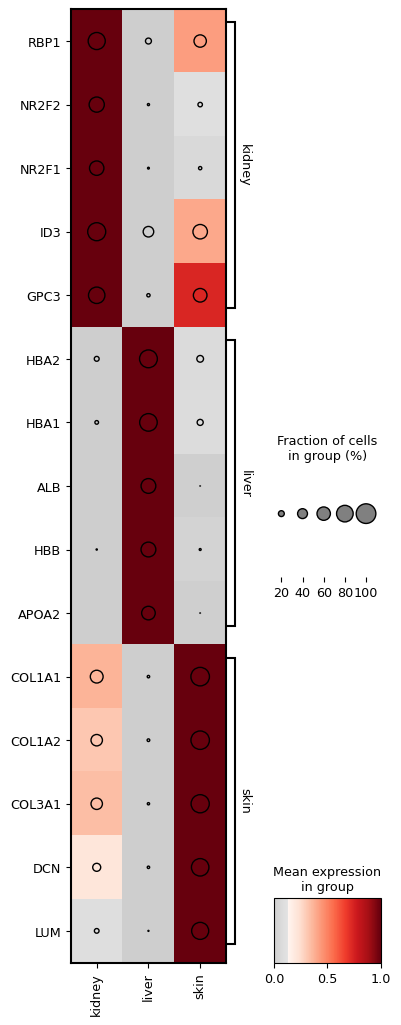

In [20]:
axs, selectedGenes_top_dict = sf.sort_and_plot(obj, selectedGenes, group_by="organ", group_by2=None, top=5, figsize=(4,12))

In [21]:
e1 = time.time()

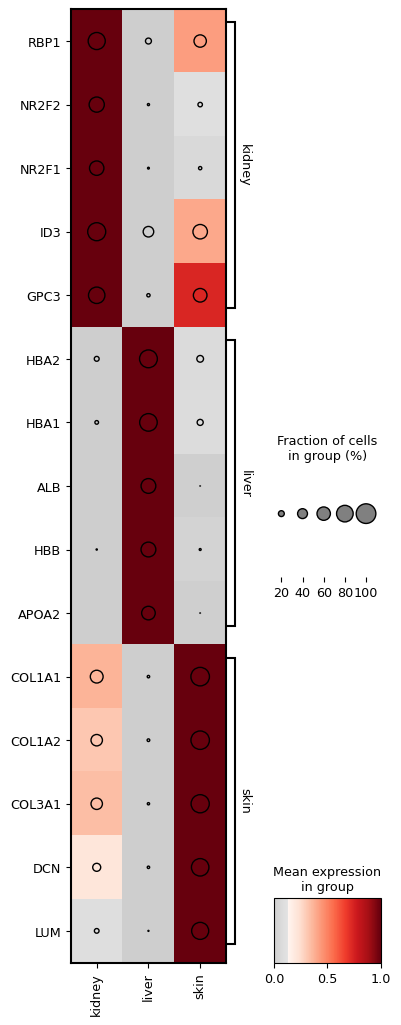

In [22]:
axs.savefig("Figures/BRF_top5_perGroup.pdf")

# Elapsed time

In [23]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

3128 genes across 42351 cells


In [24]:
print('Elapsed time (s): ', e1-s1)

Elapsed time (s):  362.7731614112854


In [25]:
print('Elapsed time (s): ', e2-s2)

Elapsed time (s):  31.58849549293518
